# Transfer Learning
In this notebook, transfer learning will be applied to pre-trained image classification CNN's for a more practical example, namely the classification of surface defects of hot-rolled steel strip.

First, the libraries are imported.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision 
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os 
import copy

c:\Users\Quinten Danneels\Documents\WP2 notebooks\Test\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Data loading** 
The dataset, which is downloaded from Kaggle (https://www.kaggle.com/datasets/kaustubhdikshit/neu-surface-defect-database), is loaded here. Data augmentation is also performed to obtain samples to train on. The dataset is divided in batches of 10. In the end of this section, the bathc of images will be visualised

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

First, the transformations for both the training and validation dataset are defined.

In [3]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

# transforms.compose is used to perform multiple sequential transformations on an image 
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(), 
        transforms.Normalize(mean,std)
    ])
}

Next, the data is loaded.

In [4]:
data_dir = 'NEU-DET' # change the path 
sets = ['train', 'val']

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) for x in sets}   # a dict is created with key values train and val. The values are the transformed data from the respective folders.
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=10,shuffle=True,num_workers=0) for x in sets} # random batches of size 10 are loaded instead of the whole dataset.
dataset_sizes = {x: len(image_datasets[x]) for x in sets}
class_names = image_datasets['train'].classes


The number of images of all classes in the training dataset is 1440 and in the validation dataset is 360. The different labels are presented below.

In [5]:
dataset_sizes, class_names

({'train': 1440, 'val': 360},
 ['crazing',
  'inclusion',
  'patches',
  'pitted_surface',
  'rolled-in_scale',
  'scratches'])

A function is written to show the images with its corresponding label. 

In [6]:
def imshow(inp,title):
    inp = inp.numpy().transpose((1,2,0))
    inp = std * inp + mean
    inp = np.clip(inp,0,1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

Select a batch of the training data.

In [9]:
inputs, classes = next(iter(dataloaders['train'])) # iterate through the batch to obtain the individual images and its labels

out = torchvision.utils.make_grid(inputs, nrow=5) # organizing the images in a grid structure

In [11]:
out.shape

torch.Size([3, 454, 1132])

Now, we use the imshow function to visualise the image batch.

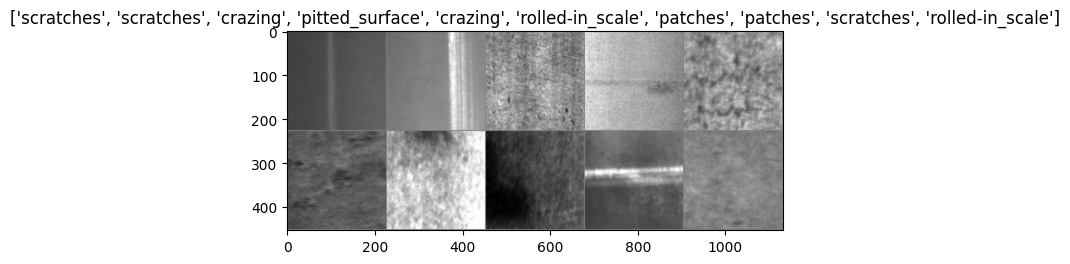

In [8]:
imshow(out, title=[class_names[x] for x in classes])

## **Model training** 
The transfer learning training loop will be defined here. The training loop is used to train the classification layers of the new model. 

In [36]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())  # takes a copy of the model and also of all the inner layers, weights, biases
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-'*10)

        # each epoch has a training and validation phase
        for phase in ['train','val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            #iterate over data 
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)  # store the inputs to the selected device
                labels = labels.to(device)  # store the labels to the selected device

                # forward step
                with torch.set_grad_enabled(phase=='train'):    # gradient calculation will only be enabled when in training mode
                    outputs = model(inputs)
                    _, preds = torch.max(outputs,1)     # preds are the indices of the max value
                    loss = criterion(outputs, labels)

                    # backward step and optimise only in train phase
                    if phase=='train':
                        optimizer.zero_grad()   # Pytorch keeps track of the gradients over multiple epochs, therefore initialise it to 0
                        loss.backward()
                        optimizer.step()    # update the model parameters using the defined optimizer 
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds==labels.data) 
            
            if phase=='train':
                scheduler.step()

            epoch_loss = running_loss/dataset_sizes[phase]
            epoch_acc = running_corrects.double()/dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase,epoch_loss,epoch_acc))

            # deep copy the model
            if phase=='val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            print()

    print('Best val Acc: {:.4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Now, load a pretrained model and reset the final fully connected layer.

In [ ]:
model = models.resnet18(pretrained=True)   # change to other models
for param in model.parameters():    # freezing all the parameters except the ones which are created after this for loop
    param.requires_grad = False
    
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, len(class_names))    # the outputs are the amount of class labels
model = model.to(device)

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.001)
step_lr_scheduler = lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)    # StepLR decays the learning rate every 7 epochs by a factor of 0.1

In [ ]:
model = train_model(model,criterion,optimizer,step_lr_scheduler,num_epochs=5)

The transfer learning of the Resnet18 model yields very good results. This model can now be used on a test dataset to measure the performance. 